# Exploring the Parameter Space


In [2]:
# make graphs look nice
import seaborn as sns
sns.set()

In [3]:
from schelling_simulation import *

In [5]:
from mesa.batchrunner import BatchRunner

def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

In [7]:
variable_params = {"homophily": range(1,9)}
fixed_params =  {"height": 10, "width": 10, "density": 0.8, "minority_percent": 0.2} 
model_reporters = {"Segregated_Agents": get_segregation}
param_sweep = BatchRunner(SchellingModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=200, 
                          model_reporters=model_reporters, 
                          display_progress=True)

In [8]:
param_sweep.run_all()

80it [00:21,  3.64it/s] 


In [9]:
df = param_sweep.get_model_vars_dataframe()
df

,homophily,Run,Segregated_Agents,height,width,density,minority_percent
0,1,0,0.246914,10,10,0.8,0.2
1,1,1,0.282051,10,10,0.8,0.2
2,1,2,0.080460,10,10,0.8,0.2
3,1,3,0.186047,10,10,0.8,0.2
4,1,4,0.213333,10,10,0.8,0.2
...,...,...,...,...,...,...,...
75,8,75,0.131579,10,10,0.8,0.2
76,8,76,0.064103,10,10,0.8,0.2
77,8,77,0.115385,10,10,0.8,0.2
78,8,78,0.194805,10,10,0.8,0.2


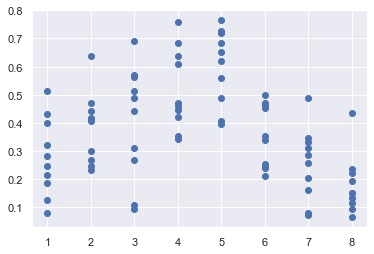

In [10]:
import matplotlib.pyplot as plt

plt.scatter(df.homophily, df.Segregated_Agents)
plt.grid(True)

In [14]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import random
import nashpy as nash
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import widgets, interact, interact_manual
import seaborn as sns
import numpy as np
import pandas


In [147]:
# Create some games:

A = np.array([[3, 0], [4, 1]])
B = np.array([[3, 4], [0, 1]])
pd = nash.Game(A, B)
#print(pd)

A = np.array([[3, 0], [6, 1]])
B = np.array([[3, 6], [0, 1]])
pd2 = nash.Game(A, B)
#print(pd2)

A = np.array([[1, 0], [0, 1]])
B = np.array([[1, 0], [0, 1]])
coord = nash.Game(A, B)
#print(coord)

A = np.array([[2, 0], [0, 1]])
B = np.array([[2, 0], [0, 1]])
hilo = nash.Game(A, B)
#print(hilo)


A = np.array([[2, 0], [0, 1]])
B = np.array([[1, 0], [0, 2]])
bos = nash.Game(A, B)
#print(bos)

A = np.array([[4, 1], [3, 2]])
B = np.array([[4, 3], [1, 2]])
sh = nash.Game(A, B)
#print(sh)

A = np.array([[9, 0], [8, 7]])
B = np.array([[9, 8], [0, 7]])
sh2 = nash.Game(A, B)
#print(str(sh2))


In [148]:

# fix two strategies
S1 = np.array([1, 0])
S2 = np.array([0, 1])

STRATS = {
    "S1": S1,
    "S2": S2
}

class Player(Agent):
    '''
    A player for a game 
    '''
    def __init__(self, unique_id, pos, model, strat):

        super().__init__(unique_id, model)
        self.pos = pos
        self.strat = strat # fixed strategy to play in the game 

    def average_payout(self):
        '''find the average payout when playing the game against all neighbors'''
        neighbors = self.model.grid.neighbor_iter(self.pos)
        return np.average([self.model.game[STRATS[self.strat], STRATS[n.strat]][0] for n in neighbors])
    
    def total_payout(self):
        '''find the total payout when playing the game against all neighbors'''
        neighbors = self.model.grid.neighbor_iter(self.pos)
        return np.sum([self.model.game[STRATS[self.strat], STRATS[n.strat]][0] for n in neighbors])
    
    def step(self):
        pass

In [204]:
x = [1,2,3,4,5]

print(x)
sq_x = list()
for i in x: 
    sq_x.append(i**2)
print(sq_x)

print(np.sum([i**2 for i in x]))


[1, 2, 3, 4, 5]
[1, 4, 9, 16, 25]
55


In [208]:
if random.random() < 0.2: 
    x = "S1"
else: 
    x = "S2"

x = "S1" if random.random() < 0.2 else "S2"
print(x)

S2


In [215]:
x = {1: "hello", "another key": 3}

print(x)

print(x[1])

print(x['another key'])

y = {i: i**2 for i in range(10)}

print(y)

print(list(y.values()))
print(list(y.keys()))

{1: 'hello', 'another key': 3}
hello
3
{0: 0, 1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49, 8: 64, 9: 81}
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [223]:
print(np.random.choice([0,1,2,3],3,[2, 1, 0, 1]))

[0 2 2]


In [224]:
class GameLatticeModel(Model):
    '''
    Play a fixed game on a lattice.
    '''
    def __init__(self, height, width, game, bias_S1, num_changes_per_step, mutation, update_type):
        
        self.height = height
        self.width = width
        self.game = game
        self.bias_S1 = bias_S1
        self.update_type = update_type
        self.num_changes_per_step = num_changes_per_step
        self.mutation = mutation
        
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)
        
        self.datacollector = DataCollector(
             {"Percent S1": lambda m: np.sum([1 for a in m.schedule.agents 
                                              if   a.strat ==  "S1"]) / m.schedule.get_agent_count()}             )
        self.running = True
        
        # Set up agents
        agent_id = 0
        for cell in self.grid.coord_iter():
            _,x,y = cell
            strat = "S1" if random.random() < self.bias_S1 else "S2"
            agent = Player(agent_id, (x, y), self, strat)
            self.grid.position_agent(agent, x=x, y=y)
            self.schedule.add(agent)
            agent_id += 1
        
    def step(self):
        for i in range(self.num_changes_per_step):
            
            # choose a random agent
            focal_agent = np.random.choice(self.schedule.agents)
            
            # find all the neighbors of the agent
            neighbors = self.grid.get_neighbors(focal_agent.pos, moore=True)
            
            
            if self.update_type == 'imitator':
                # imitate most successful neighbor
                total_payouts  = {a: a.total_payout() for a in neighbors}

                max_payout = max(total_payouts.values())

                strat_to_imitate = [a.strat for a in total_payouts.keys() if total_payouts[a] == max_payout][0]

            if self.update_type == 'prob_imitator':
                
                # get the average payouts for each neighbor
                average_payouts = [a.average_payout() for a in neighbors]
                total_average_payouts = np.sum(average_payouts)
                
                # probabilities for each neighbor
                neighbor_probs = [n.average_payout() / total_average_payouts for n in neighbors]
                
                # probabilistically imitate most successful neighbor 
                strat_to_imitate = np.random.choice(neighbors, 1, p=neighbor_probs)[0].strat
            
            
            # mutations
            other_strat = "S2" if strat_to_imitate == "S1" else "S1"
            
            if random.random() < self.mutation:
                focal_agent.strat = other_strat
            else: 
                focal_agent.strat = strat_to_imitate
            
            self.datacollector.collect(self)
            
            self.schedule.steps += 1
        
        # stop running if all agents have the same strategy

        if all([a.strat == "S1" for a in self.schedule.agents]) or all([a.strat == "S2" for a in self.schedule.agents]):
            self.running=False
            
            

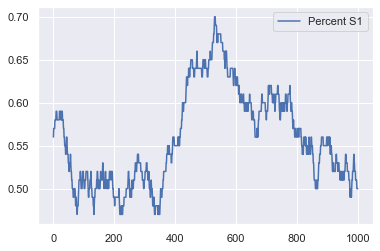

In [225]:

## Visualization
import tqdm.notebook as tqdm 

height, width = 10, 10 
game = sh
bias_S1 = 0.5
mutation = 0.1
update_type = 'prob_imitator'
num_changes_per_step = 1
model = GameLatticeModel(height, 
                         width, 
                         game, 
                         bias_S1, 
                         num_changes_per_step, 
                         mutation, 
                         update_type)


for i in tqdm.tqdm(range(1000)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();

In [226]:
def get_percentS1(m):
    '''
    Find the % of agents playing the strategy S1.
    '''
    
    return np.sum([1 for a in m.schedule.agents
                   if a.strat == "S1"]) / m.schedule.get_agent_count()


In [227]:
variable_params = {"mutation": [0.0, 0.1, 0.2, 0.3]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "update_type": "imitator", 
                 "game": sh,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=5, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=True)

In [228]:
param_sweep.run_all()

20it [00:55,  2.78s/it]


In [118]:
df = param_sweep.get_model_vars_dataframe()
df

,mutation,Run,PercentS1,height,width,bias_S1,update_type,game,num_changes_per_step
0,0.0,0,0.9050,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
1,0.0,1,0.9450,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
2,0.0,2,0.9175,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
3,0.0,3,0.8675,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
4,0.0,4,0.8650,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
5,0.1,5,0.8550,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
6,0.1,6,0.8500,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
7,0.1,7,0.7450,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
8,0.1,8,0.8275,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
9,0.1,9,0.8300,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1


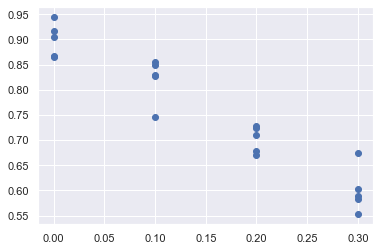

In [119]:
plt.scatter(df.mutation, df.PercentS1)
plt.title("Imitator, different games")
plt.ylabel("Percet S1")
plt.xlabel("mutation")
plt.grid(True)

In [120]:

A = np.array([[4, 1], [3, 2]])
B = np.array([[4, 3], [1, 2]])
sh0 = nash.Game(A, B)
#print(sh)

A = np.array([[5, 1], [3, 2]])
B = np.array([[5, 3], [1, 2]])
sh1 = nash.Game(A, B)
#print(sh)

A = np.array([[6, 1], [3, 2]])
B = np.array([[6, 3], [1, 2]])
sh2 = nash.Game(A, B)
#print(sh)

A = np.array([[7, 1], [3, 2]])
B = np.array([[7, 3], [1, 2]])
sh3 = nash.Game(A, B)
#print(sh)

A = np.array([[8, 1], [3, 2]])
B = np.array([[8, 3], [1, 2]])
sh4 = nash.Game(A, B)
#print(sh)

A = np.array([[9, 1], [3, 2]])
B = np.array([[9, 3], [1, 2]])
sh5 = nash.Game(A, B)
#print(sh)



In [140]:
variable_params = {"game": [sh0, sh1, sh2, sh3, sh4, sh5]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "update_type": "prob_imitator", 
                 "mutation": 0.0,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=5, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=True)

In [141]:
param_sweep.run_all()

30it [01:19,  2.64s/it]


In [144]:
df = param_sweep.get_model_vars_dataframe()


In [145]:
def convert_sh_string(gstr):
    
    if gstr == str(sh0):
        return "4"
    if gstr == str(sh1):
        return "5"
    if gstr == str(sh2):
        return "6"
    if gstr == str(sh3):
        return "7"
    if gstr == str(sh4):
        return "8"
    if gstr == str(sh5):
        return "9"
    return gstr
    

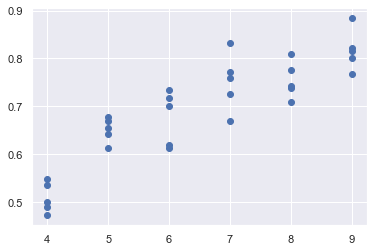

In [146]:
plt.scatter([convert_sh_string(str(g)) for g in df.game], df.PercentS1)
plt.title("Prob Imitatory, different SH games")
plt.ylabel("Percet S1")
plt.xlabel("(S1, S1) Payout")
plt.grid(True)

In [152]:
variable_params = {"game": [pd, pd2, coord, hilo, bos, sh, sh2]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "update_type": "prob_imitator", 
                 "mutation": 0.0,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=True)


In [153]:
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()


70it [02:59,  2.56s/it]


In [154]:
def convert_game_string(gstr):
    
    if gstr == str(pd):
        return "PD"
    if gstr == str(pd2):
        return "PD2"
    if gstr == str(coord):
        return "Coord"
    if gstr == str(hilo):
        return "HiLo"
    if gstr == str(bos):
        return "BoS"
    if gstr == str(sh):
        return "SH"
    if gstr == str(sh2):
        return "SH2"
    return gstr
    

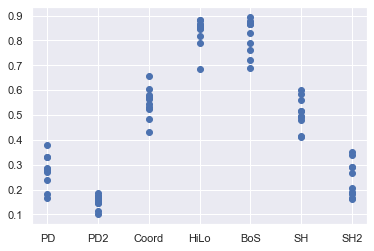

In [155]:
plt.scatter([convert_game_string(str(g)) for g in df.game], df.PercentS1)
plt.title("Prob Imitatory, different games")
plt.ylabel("Percet S1")
plt.xlabel("Game")
plt.grid(True)

In [156]:
variable_params = {"game": [pd, pd2, coord, hilo, bos, sh, sh2]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "update_type": "imitator", 
                 "mutation": 0.0,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=True)


In [157]:
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()


70it [01:50,  1.58s/it]


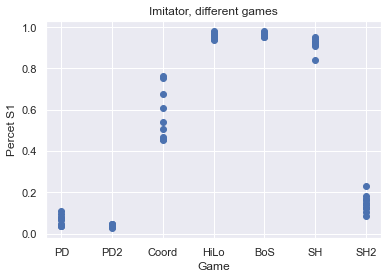

In [159]:
plt.scatter([convert_game_string(str(g)) for g in df.game], df.PercentS1)
plt.title("Imitator, different games")
plt.ylabel("Percet S1")
plt.xlabel("Game")
plt.grid(True)

In [176]:
variable_params = {"game": [pd, pd2, coord, hilo, bos, sh, sh2], 
                   "update_type": ["imitator", "prob_imitator"]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "mutation": 0.0,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=True)


In [177]:
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()


140it [04:57,  2.12s/it]


In [179]:
df 

,update_type,game,Run,PercentS1,height,width,bias_S1,mutation,num_changes_per_step
0,Bi matrix game with payoff matrices:\n\nRow pl...,imitator,0,0.0600,20,20,0.5,0.0,1
1,Bi matrix game with payoff matrices:\n\nRow pl...,imitator,1,0.0375,20,20,0.5,0.0,1
2,Bi matrix game with payoff matrices:\n\nRow pl...,imitator,2,0.0300,20,20,0.5,0.0,1
3,Bi matrix game with payoff matrices:\n\nRow pl...,imitator,3,0.0450,20,20,0.5,0.0,1
4,Bi matrix game with payoff matrices:\n\nRow pl...,imitator,4,0.0275,20,20,0.5,0.0,1
...,...,...,...,...,...,...,...,...,...
135,Bi matrix game with payoff matrices:\n\nRow pl...,prob_imitator,135,0.1375,20,20,0.5,0.0,1
136,Bi matrix game with payoff matrices:\n\nRow pl...,prob_imitator,136,0.1800,20,20,0.5,0.0,1
137,Bi matrix game with payoff matrices:\n\nRow pl...,prob_imitator,137,0.2675,20,20,0.5,0.0,1
138,Bi matrix game with payoff matrices:\n\nRow pl...,prob_imitator,138,0.2475,20,20,0.5,0.0,1


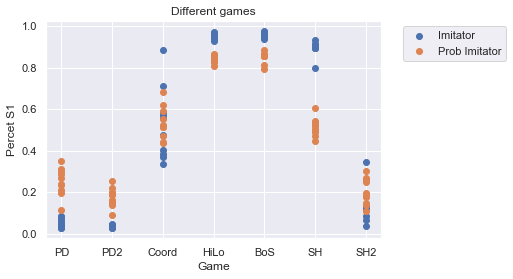

In [180]:
plt.scatter([convert_game_string(str(g)) for g in df[df["game"] == "imitator"].update_type],  
            df[df["game"] == "imitator"].PercentS1, label="Imitator")
plt.scatter([convert_game_string(str(g)) for g in df[df["game"] == "prob_imitator"].update_type], 
            df[df["game"] == "prob_imitator"].PercentS1, label="Prob Imitator")
plt.title("Different games")
plt.ylabel("Percet S1")
plt.xlabel("Game")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)

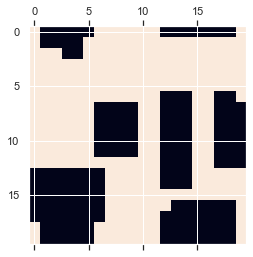

In [196]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

height, width = 20, 20 
game = pd
bias_S1 = 0.8
mutation = 0.0
update_type = 'imitator'
num_changes_per_step = 100
model = GameLatticeModel(height, 
                         width, 
                         game, 
                         bias_S1, 
                         num_changes_per_step, 
                         mutation, 
                         update_type)

def generate_data():
    model.step()
    data = np.array([[0 if  c.strat == "S1" else 1 for c in row] for row in model.grid.grid])
    df = pandas.DataFrame(data)
    return df 

def update(data):
    mat.set_data(data)
    return mat 

def data_gen():
    while True:
        yield generate_data()

fig, ax = plt.subplots()
mat = ax.matshow(generate_data())
#plt.colorbar(mat)
ani = animation.FuncAnimation(fig, update, data_gen, interval=500,
                               save_count=50)
# plt.show()
HTML(ani.to_jshtml())


In [157]:
import cProfile

cProfile.run('model.step()')

         19223 function calls in 0.014 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1201    0.001    0.000    0.007    0.000 <__array_function__ internals>:2(array_equal)
       16    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(average)
      512    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(dot)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(prod)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(sum)
       16    0.000    0.000    0.005    0.000 <ipython-input-150-98c02a594bd6>:15(average_payout)
       16    0.000    0.000    0.004    0.000 <ipython-input-150-98c02a594bd6>:18(<listcomp>)
        1    0.000    0.000    0.003    0.003 <ipython-input-151-512172118dbc>:19(<lambda>)
        1    0.000    0.000    0.003    0.003 <ipython-input-151-512172118dbc>:19(<listcomp>)
        1    0.000    0.000    0.014   